In [162]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,RobustScaler
from sklearn.metrics import mean_squared_error,r2_score
import random

In [163]:
# Seed Python, NumPy, and TensorFlow RNGs
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Import the data

In [3]:
SPY = pd.read_pickle('combined_cleaned_add_with_QQQ.pkl')
SPY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2055 entries, 0 to 2054
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ds                   2055 non-null   datetime64[ns]
 1   SPY_Close            2055 non-null   float64       
 2   SPY_Volume           2055 non-null   int64         
 3   AAPL                 2055 non-null   float64       
 4   MSFT                 2055 non-null   float64       
 5   GOOG                 2055 non-null   float64       
 6   GLD                  2055 non-null   float64       
 7   SLV                  2055 non-null   float64       
 8   ^TNX                 2055 non-null   float64       
 9   DX-Y.NYB             2055 non-null   float64       
 10  JPY=X                2055 non-null   float64       
 11  EUR=X                2055 non-null   float64       
 12  USO                  2055 non-null   float64       
 13  UNG                  2055 non-nul

# Add support and resistance areas

In [131]:
from scipy.signal import argrelextrema
spy_zones = SPY.copy()

# Use N = window size to define "local"
N = 10

# Find local maxima (resistance) and minima (support)
spy_zones['local_max'] = spy_zones['SPY_Close'].iloc[argrelextrema(spy_zones['SPY_Close'].values, np.greater_equal, order=N)[0]]
spy_zones['local_min'] = spy_zones['SPY_Close'].iloc[argrelextrema(spy_zones['SPY_Close'].values, np.less_equal, order=N)[0]]


# Define zone precision (e.g., $100 buckets)
zone_precision = 100
support_levels = spy_zones['local_min'].dropna().round(-int(np.log10(zone_precision)))
resistance_levels = spy_zones['local_max'].dropna().round(-int(np.log10(zone_precision)))

support_zones = support_levels.value_counts().loc[lambda x: x > 1].index.tolist()
resistance_zones = resistance_levels.value_counts().loc[lambda x: x > 1].index.tolist()

In [132]:
# define your margins
margin_sup = 50.0    # dollars above support to trigger 1
margin_res = 50.0    # dollars below resistance to trigger -1

def support_signal(price):
    # compute (distance, support) for only those supports below or equal to price
    diffs = [(price - s, s) for s in support_zones if s <= price]
    if not diffs:
        return 0
    # pick the smallest positive distance
    nearest_diff, nearest_sup = min(diffs, key=lambda x: x[0])
    return 1 if nearest_diff <= margin_sup else 0

def resistance_signal(price):
    # compute (distance, resistance) for only those resistances above or equal to price
    diffs = [(r - price, r) for r in resistance_zones if r >= price]
    if not diffs:
        return 0
    nearest_diff, nearest_res = min(diffs, key=lambda x: x[0])
    return -1 if nearest_diff <= margin_res else 0

# apply to your DataFrame
spy_zones['SUPPORT_Signal']    = spy_zones['SPY_Close'].apply(support_signal)
spy_zones['RESISTANCE_Signal'] = spy_zones['SPY_Close'].apply(resistance_signal)

# quick check
print(spy_zones[['SPY_Close','SUPPORT_Signal','RESISTANCE_Signal']].tail(60))


        SPY_Close  SUPPORT_Signal  RESISTANCE_Signal
1995  6086.370117               0                 -1
1996  6118.709961               0                  0
1997  6101.240234               0                  0
1998  6012.279785               0                  0
1999  6067.700195               0                 -1
2000  6039.310059               0                  0
2001  6071.169922               0                 -1
2002  6040.529785               0                  0
2003  5994.569824               0                  0
2004  6037.879883               0                  0
2005  6061.479980               0                 -1
2006  6083.569824               0                 -1
2007  6025.990234               0                  0
2008  6066.439941               0                 -1
2009  6068.500000               0                 -1
2010  6051.970215               0                 -1
2011  6115.069824               0                  0
2012  6114.629883               0             

In [ ]:
spy_zones.info()

In [3]:
print(SPY.columns.to_list())

['ds', 'SPY_Close', 'SPY_Volume', 'AAPL', 'MSFT', 'GOOG', 'GLD', 'SLV', '^TNX', 'DX-Y.NYB', 'JPY=X', 'EUR=X', 'USO', 'UNG', 'BTC-USD', 'CPER', '^VIX', '^GDAXI', '^FTSE', '^RUT', '^N225', 'IEI', 'CNYUSD=X', '2Y_Yield', 'yield_curve', 'market_closed_count', 'yield_curve_term', 'high-low', 'before_high-low', 'SPY_RSI', 'RSI_rank', 'RSI_rank_2', 'EMA_20', 'EMA_50', 'EMA_200', 'EMA_20_50', 'EMA_50_200', 'EMA_50_diff', 'EMA_200_diff', 'SPY_std', 'SPY_mean', 'SPY_30', 'QQQ_Close', 'QQQ_Volume', 'qqq_std', 'qqq_mean']


## Add RSI , MACD & averages

In [4]:
def calculate_rsi(prices, period=14):
    prices = pd.to_numeric(prices, errors='coerce')
    delta  = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

  # MACD Calculation
def calculate_macd(prices, fast=12, slow=26):
    prices = pd.Series(prices).astype(float).dropna()
    exp1 = prices.ewm(span=fast, adjust=False).mean()
    exp2 = prices.ewm(span=slow, adjust=False).mean()
    return exp1 - exp2

# number of consecative up/down days     
def calculate_consecutive_streak(close_series: pd.Series) -> pd.Series:
    """
    Calculate the consecutive up/down streaks for a close price series.
    - If today's close > yesterday's, streak = previous_streak + 1 (or 1 if previous_streak <= 0)
    - If today's close < yesterday's, streak = previous_streak - 1 (or -1 if previous_streak >= 0)
    - If equal, streak = 0
    """
    streak = [0] * len(close_series)
    for i in range(1, len(close_series)):
        if close_series.iat[i] > close_series.iat[i - 1]:
            streak[i] = streak[i - 1] + 1 if streak[i - 1] > 0 else 1
        elif close_series.iat[i] < close_series.iat[i - 1]:
            streak[i] = streak[i - 1] - 1 if streak[i - 1] < 0 else -1
        else:
            streak[i] = 0
    return pd.Series(streak, index=close_series.index, name='consecutive_streak')

# Add some internal features 
#
def model_own_features(
    data: pd.DataFrame,
    column: str,
    keep_columns = None
) -> pd.DataFrame:
    """
    Add RSI, MACD, rolling means, std, and consecutive streak for `column`.
    Optionally preserve only keep_columns + new features.
    """
    df = data.copy()
    # Ensure numeric
    df[column] = pd.to_numeric(df[column], errors='coerce')
    
    # 1) RSI
    df['RSI_14'] = calculate_rsi(df[column], period=14)
    
    # 2) MACD
    #macd_df = calculate_macd(df[column])
    #df = df.join(macd_df)
    df['MACD'] = calculate_macd(df[column])
    # 3) Rolling stats
    df['20d_mean'] = df[column].rolling(20).mean()
    df['5d_mean']  = df[column].rolling(5).mean()
    df['5d_std']   = df[column].rolling(5).std()
    
    # 4) Consecutive streak
    df['streak'] = calculate_consecutive_streak(df[column])
    
    # 5) Select output columns
    if keep_columns is not None:
        # always include the new features
        new_feats = ['RSI_14', 'MACD', '20d_mean', '5d_mean', '5d_std', 'streak']
        df = df[ keep_columns + new_feats ]

    df = df.dropna()

    return df


In [5]:
# calculate the cosecative returns
def calculate_consecutive_return(close_series: pd.Series, streak_series: pd.Series) -> pd.Series:
    """
    Calculate the percentage change over the span of the consecutive streak.
    - If streak == 0: 0
    - Else: (close_today / close_n_days_ago - 1) * 100, where n = abs(streak)
    """
    returns = []
    prices = close_series.values
    streaks = streak_series.values.astype(int)
    for i, (price, streak) in enumerate(zip(prices, streaks)):
        n = abs(streak)
        if n > 0 and i - n >= 0:
            prev_price = prices[i - n]
            returns.append((price / prev_price - 1) * 100)
        else:
            returns.append(0.0)
    return pd.Series(returns, index=close_series.index, name='abs_consecutive_change')



### Add date features

In [6]:
def date_features(df):
    df['month'] = df['ds'].dt.month
    df['day_of_week'] = df['ds'].dt.dayofweek
    df['day_of_week'] = df['day_of_week'] + 2
    return df

In [11]:
result = model_own_features(
    data=SPY,
    column='SPY_Close',
    keep_columns=['SPY_Close','high-low','before_high-low','SPY_Volume','ds']
)

result['abs_consecutive_change'] = calculate_consecutive_return(result['SPY_Close'], result['streak'])
result = date_features(result) # to add date features
result = result.drop('ds',axis=1) # drop the date column
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2036 entries, 19 to 2054
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SPY_Close               2036 non-null   float64
 1   high-low                2036 non-null   float64
 2   before_high-low         2036 non-null   float64
 3   SPY_Volume              2036 non-null   int64  
 4   RSI_14                  2036 non-null   float64
 5   MACD                    2036 non-null   float64
 6   20d_mean                2036 non-null   float64
 7   5d_mean                 2036 non-null   float64
 8   5d_std                  2036 non-null   float64
 9   streak                  2036 non-null   int64  
 10  abs_consecutive_change  2036 non-null   float64
 11  month                   2036 non-null   int32  
 12  day_of_week             2036 non-null   int32  
dtypes: float64(9), int32(2), int64(2)
memory usage: 206.8 KB


In [12]:
result = result.reset_index(drop=True)

result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SPY_Close               2036 non-null   float64
 1   high-low                2036 non-null   float64
 2   before_high-low         2036 non-null   float64
 3   SPY_Volume              2036 non-null   int64  
 4   RSI_14                  2036 non-null   float64
 5   MACD                    2036 non-null   float64
 6   20d_mean                2036 non-null   float64
 7   5d_mean                 2036 non-null   float64
 8   5d_std                  2036 non-null   float64
 9   streak                  2036 non-null   int64  
 10  abs_consecutive_change  2036 non-null   float64
 11  month                   2036 non-null   int32  
 12  day_of_week             2036 non-null   int32  
dtypes: float64(9), int32(2), int64(2)
memory usage: 191.0 KB


### Creat a sequence

In [13]:
def create_sequences_multifeature(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i, 0])  # תחזית רק למחיר
    return np.array(X), np.array(y)

window_size = 30
#X, y = create_sequences_multifeature(scaled_data, window_size)

### Scaling, Creating a sequence & spliting the data

In [14]:
scaler = MinMaxScaler() # scale the data
def prepare_RNN_data(data,window_size,scaler,split_ratio=0.8):
    
    scaled_data = scaler.fit_transform(data)

    X, y = create_sequences_multifeature(scaled_data, window_size)
    split = int(split_ratio * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    return X_train, X_test, y_train, y_test ,X

In [15]:
window_size = 30
X_train, X_test, y_train, y_test,X = prepare_RNN_data(result, 30,scaler) # for sequence length of 30

# Search for the best parameters

In [159]:
import itertools

def search_best_model(
    model_type: str,
    X_train, y_train,
    X_val, y_val,
    window_size: int,
    layer_options=(1, 2, 3),
    unit_options=(32, 64, 98),
    learning_rates=(0.001,),
    learning_rate=None,
    epochs=20,
    batch_size=32,
    patience=3,
    loss='mse',
    dense_units=None,
    dense_activation='relu',
    dropout_rate=None,
    shuffle=False
):
    """
    Grid-search over GRU/LSTM architectures to minimize validation loss,
    with optional Dense and Dropout layers, and search over learning rates.

    Parameters
    ----------
    model_type : {"GRU", "LSTM"}
    X_train, y_train : np.ndarray
    X_val, y_val : np.ndarray
    window_size : int
    layer_options : iterable of int
    unit_options : iterable of int
    learning_rates : iterable of float
    learning_rate : float or None
    epochs : int
    batch_size : int
    patience : int
    loss : str
    dense_units : int or None
    dense_activation : str
    dropout_rate : float or None
        If specified, adds Dropout(dropout_rate) after each RNN layer.
    Returns
    -------
    best_model, best_val_loss, best_config
    """
    if model_type not in ("GRU", "LSTM"):
        raise ValueError(f"model_type must be 'GRU' or 'LSTM', got {model_type!r}")
    Cell = GRU if model_type == "GRU" else LSTM

    best_val_loss = float('inf')
    best_model = None
    best_config = None

    # build learning rate list
    lr_list = (learning_rate,) if learning_rate is not None else (
        learning_rates if hasattr(learning_rates, '__iter__') and not isinstance(learning_rates, str) else (learning_rates,)
    )

    for lr in lr_list:
        for n_layers in layer_options:
            for units_combo in itertools.product(unit_options, repeat=n_layers):
                model = Sequential()
                for i, units in enumerate(units_combo):
                    return_seq = (i < n_layers - 1)
                    if i == 0:
                        model.add(Cell(units, return_sequences=return_seq,
                                       input_shape=(window_size, X_train.shape[2])))
                    else:
                        model.add(Cell(units, return_sequences=return_seq))
                    if dropout_rate is not None:
                        model.add(Dropout(dropout_rate))
                if dense_units is not None:
                    model.add(Dense(dense_units, activation=dense_activation))
                    if dropout_rate is not None:
                        model.add(Dropout(dropout_rate))
                model.add(Dense(1))

                opt = Adam(learning_rate=lr)
                model.compile(optimizer=opt, loss=loss)
                es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
                history = model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[es],
                    verbose=0,
                    shuffle= shuffle
                )
                val_loss = min(history.history['val_loss'])
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model
                    best_config = {
                        'model_type': model_type,
                        'n_layers': n_layers,
                        'units': units_combo,
                        'learning_rate': lr,
                        'dense_units': dense_units,
                        'dense_activation': dense_activation,
                        'dropout_rate': dropout_rate
                    }
    return best_model, best_val_loss, best_config


In [14]:
best_model, best_loss, best_cfg = search_best_model(
    model_type="GRU",                # or "LSTM"
    X_train=X_train, y_train=y_train,
    X_val=X_test,  y_val=y_test,
    window_size=window_size,
    layer_options=[1,2,3],
    unit_options=[32,64,92],
    epochs=20,
    batch_size=32,
    patience=3,
    learning_rate=0.004
)
print("Best loss:", best_loss, "Config:", best_cfg)


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best loss: 0.00033035248634405434 Config: (1, (64,))


In [23]:
best_model, best_loss, best_cfg = search_best_model(
    model_type="LSTM",                # or "LSTM"
    X_train=X_train, y_train=y_train,
    X_val=X_test,  y_val=y_test,
    window_size=window_size,
    layer_options=[1,2,3],
    unit_options=[32,64,92],
    epochs=20,
    batch_size=32,
    patience=3,
    learning_rate=0.004
)
print("Best loss:", best_loss, "Config:", best_cfg)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best loss: 0.0005738987820222974 Config: (1, (64,))


# Training functions

In [160]:
def train_lstm(
    X_train, y_train,
    learning_rate=0.001,
    epochs=20,
    num_layers=1,
    units=(64,),
    window_size=None,
    batch_size=32,
    validation_split=0.2,
    patience=3,
    checkpoint_path='best_lstm.h5',
    dense_units=None,
    dense_activation='relu',
    dropout_rate=None,
    shuffle=False
):
    """
    Builds, compiles, and trains a multi-layer LSTM model, with optional intermediate Dense and Dropout layers.

    Parameters:
    - X_train, y_train: training data arrays
    - learning_rate: float, optimizer learning rate
    - epochs: int, max training epochs
    - num_layers: int, number of LSTM layers
    - units: tuple of ints, units per LSTM layer (must match num_layers)
    - window_size: int, sequence length (timesteps)
    - batch_size: int
    - validation_split: float, fraction of data for validation
    - patience: int, early stopping patience
    - checkpoint_path: str, filepath to save best model
    - dense_units: int or None, adds Dense layer if specified
    - dense_activation: str, activation for the Dense layer
    - dropout_rate: float or None, adds Dropout after each layer if specified

    Returns:
    - model: trained Keras model
    - history: training history
    """
    if num_layers != len(units):
        raise ValueError(f"num_layers ({num_layers}) must equal len(units) ({len(units)})")

    opt = Adam(learning_rate=learning_rate)
    model = Sequential()

    # Add LSTM + optional Dropout
    for i, u in enumerate(units):
        return_seq = (i < num_layers - 1)
        if i == 0:
            model.add(LSTM(u, return_sequences=return_seq,
                           input_shape=(window_size, X_train.shape[2])))
        else:
            model.add(LSTM(u, return_sequences=return_seq))
        if dropout_rate is not None:
            model.add(Dropout(dropout_rate))

    # Optional intermediate Dense + Dropout
    if dense_units is not None:
        model.add(Dense(dense_units, activation=dense_activation))
        if dropout_rate is not None:
            model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))

    model.compile(optimizer=opt, loss='mse')

    # Callbacks
    es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    chk = ModelCheckpoint(filepath=checkpoint_path,
                          monitor='val_loss',
                          save_best_only=True,
                          verbose=1)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[es, chk],
        verbose=1,
        shuffle=shuffle  # Important for time series
    )
    return model, history


def train_gru(
    X_train, y_train,
    learning_rate=0.001,
    epochs=20,
    num_layers=1,
    units=(64,),
    window_size=None,
    batch_size=32,
    validation_split=0.2,
    patience=3,
    checkpoint_path='best_gru.h5',
    dense_units=None,
    dense_activation='relu',
    dropout_rate=None
):
    """
    Builds, compiles, and trains a multi-layer GRU model, with optional intermediate Dense and Dropout layers.

    Same parameters as train_lstm.

    Returns:
    - model: trained Keras model
    - history: training history
    """
    if num_layers != len(units):
        raise ValueError(f"num_layers ({num_layers}) must equal len(units) ({len(units)})")

    # Device selection for GPU
    device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
    with tf.device(device):
        opt = Adam(learning_rate=learning_rate)
        model = Sequential()

        # Add GRU + optional Dropout
        for i, u in enumerate(units):
            return_seq = (i < num_layers - 1)
            if i == 0:
                model.add(GRU(u, return_sequences=return_seq,
                              input_shape=(window_size, X_train.shape[2])))
            else:
                model.add(GRU(u, return_sequences=return_seq))
            if dropout_rate is not None:
                model.add(Dropout(dropout_rate))

        # Optional intermediate Dense + Dropout
        if dense_units is not None:
            model.add(Dense(dense_units, activation=dense_activation))
            if dropout_rate is not None:
                model.add(Dropout(dropout_rate))

        # Output layer
        model.add(Dense(1))
        model.compile(optimizer=opt, loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    chk = ModelCheckpoint(filepath=checkpoint_path,
                          monitor='val_loss',
                          save_best_only=True,
                          verbose=1)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[es, chk],
        verbose=1
    )
    return model, history


In [273]:


def train_lstm(
    X_train, y_train,
    learning_rate=0.001,
    epochs=20,
    num_layers=1,
    units=(64,),
    window_size=None,
    batch_size=32,
    validation_split=0.2,
    patience=3,
    checkpoint_path='best_lstm.h5',
    dense_units=None,
    dense_activation='relu'
):
    """
    Builds, compiles, and trains a multi-layer LSTM model, with optional intermediate Dense layer.

    Parameters:
    - X_train, y_train: training data arrays
    - learning_rate: float, optimizer learning rate
    - epochs: int, max training epochs
    - num_layers: int, number of LSTM layers
    - units: tuple of ints, units per LSTM layer (length must equal num_layers)
    - window_size: int, sequence length (timesteps)
    - batch_size: int
    - validation_split: float
    - patience: int, early stopping patience
    - checkpoint_path: str, filepath to save best model
    - dense_units: int or None, if specified adds Dense(dense_units, activation=dense_activation)
    - dense_activation: str, activation for the optional Dense layer

    Returns:
    - model: trained Keras model
    - history: training history
    """
    if num_layers != len(units):
        raise ValueError(f"num_layers ({num_layers}) must equal length of units tuple ({len(units)})")
    
    opt = Adam(learning_rate=learning_rate)
    model = Sequential()
    
    # Add LSTM layers
    for i, u in enumerate(units):
        return_seq = (i < num_layers - 1)
        if i == 0:
            model.add(LSTM(u, return_sequences=return_seq, input_shape=(window_size, X_train.shape[2])))
        else:
            model.add(LSTM(u, return_sequences=return_seq))
    
    # Optional Dense layer
    if dense_units is not None:
        model.add(Dense(dense_units, activation=dense_activation))
    # Output layer
    model.add(Dense(1))
    
    model.compile(optimizer=opt, loss='mse')
    
    es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    chk = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',
                          save_best_only=True, verbose=1)
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[es, chk],
        verbose=1
    )
    return model, history

def train_gru(
    X_train, y_train,
    learning_rate=0.001,
    epochs=20,
    num_layers=1,
    units=(64,),
    window_size=None,
    batch_size=32,
    validation_split=0.2,
    patience=3,
    checkpoint_path='best_gru.h5',
    dense_units=None,
    dense_activation='relu'
):
    """
    Builds, compiles, and trains a multi-layer GRU model (on GPU if available), with optional Dense layer.

    Parameters: same as train_lstm.
    """
    if num_layers != len(units):
        raise ValueError(f"num_layers ({num_layers}) must equal length of units tuple ({len(units)})")
    
    # Choose device
    device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
    with tf.device(device):
        opt = Adam(learning_rate=learning_rate)
        model = Sequential()
        # Add GRU layers
        for i, u in enumerate(units):
            return_seq = (i < num_layers - 1)
            if i == 0:
                model.add(GRU(u, return_sequences=return_seq, input_shape=(window_size, X_train.shape[2])))
            else:
                model.add(GRU(u, return_sequences=return_seq))
        # Optional Dense layer
        if dense_units is not None:
            model.add(Dense(dense_units, activation=dense_activation))
        # Output layer
        model.add(Dense(1))
        model.compile(optimizer=opt, loss='mse')
    
    es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    chk = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',
                          save_best_only=True, verbose=1)
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[es, chk],
        verbose=1
    )
    return model, history


### plotting for each epoch

In [88]:
def plot_training_history(history, title="Model Loss"):
    """
    Plots training & validation loss curves from a Keras History object.
    
    history: the History returned by model.fit(...)
    title:   optional title for the plot
    """
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'o-', label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(epochs, history.history['val_loss'], 's--', label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

### LSTM

In [ ]:
model_lstm = train_lstm(
    X_train, y_train,
    learning_rate=0.005,
    epochs=30,
    num_layers=1,
    units=(64,),
    window_size=30,
    batch_size=16,
    validation_split=0.2,
    patience=5,
    checkpoint_path='best_lstm.h5',
    dense_units=None,
    dense_activation='relu'
)[0]

Epoch 1/30


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0124
Epoch 1: val_loss improved from inf to 0.00052, saving model to best_lstm.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0120 - val_loss: 5.2447e-04
Epoch 2/30
72/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9600e-04
Epoch 2: val_loss improved from 0.00052 to 0.00028, saving model to best_lstm.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9698e-04 - val_loss: 2.7928e-04
Epoch 3/30
73/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8164e-04
Epoch 3: val_loss improved from 0.00028 to 0.00027, saving model to best_lstm.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8120e-04 - val_loss: 2.7307e-04
Epoch 4/30
75/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8939e-04
Epoch 4: val_loss did not improve from 0.00027
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8967e-04 - val_loss: 2.7311e-04
Epoch 5/30
75/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4689e-04
Epoch 5: val_loss did not improve from 0.00027
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5080e-04 - val_loss: 2.9829e-04
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7913e-04
Epoch 6: val_loss did not improve from 0.00027
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7895e-04 - val_loss: 4.7888e-04
Epoch 7/30
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8124e-04
Epoch 7: val_loss did not improve from 0.00027
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8102e-04 - val_loss: 4.3308e-04
Epoch 8/30
73/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2496e-04
Epoch 8: val_loss did not improve from 0.00027
80/80 ━━━━━━━━━

### GRU

In [20]:
model_gru = train_gru(
    X_train, y_train,
    learning_rate=0.005,
    epochs=30,
    num_layers=1,
    units=(64,),
    window_size=30,
    batch_size=32,
    validation_split=0.2,
    patience=5,
    checkpoint_path='best_gru.h5',
    dense_units=None,
    dense_activation='relu'
)[0]

Epoch 1/30


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0475
Epoch 1: val_loss improved from inf to 0.00062, saving model to best_gru.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0452 - val_loss: 6.1975e-04
Epoch 2/30
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1282e-04
Epoch 2: val_loss improved from 0.00062 to 0.00023, saving model to best_gru.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0807e-04 - val_loss: 2.3276e-04
Epoch 3/30
36/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3453e-04
Epoch 3: val_loss improved from 0.00023 to 0.00022, saving model to best_gru.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3597e-04 - val_loss: 2.1623e-04
Epoch 4/30
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3488e-04
Epoch 4: val_loss improved from 0.00022 to 0.00021, saving model to best_gru.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3536e-04 - val_loss: 2.0987e-04
Epoch 5/30
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3927e-04
Epoch 5: val_loss improved from 0.00021 to 0.00021, saving model to best_gru.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3903e-04 - val_loss: 2.0721e-04
Epoch 6/30
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2248e-04
Epoch 6: val_loss improved from 0.00021 to 0.00019, saving model to best_gru.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2297e-04 - val_loss: 1.9297e-04
Epoch 7/30
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2150e-04
Epoch 7: val_loss improved from 0.00019 to 0.00019, saving model to best_gru.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2179e-04 - val_loss: 1.8589e-04
Epoch 8/30
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4379e-04
Epoch 8: val_loss did not improve from 0.00019
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4150e-04 - val_loss: 1.9708e-04
Epoch 9/30
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1968e-04
Epoch 9: val_loss did not improve from 0.00019
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1904e-04 - val_loss: 1.8600e-04
Epoch 10/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2221e-04
Epoch 10: val_loss did not improve from 0.00019
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2252e-04 - val_loss: 2.0288e-04
Epoch 11/30
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0707e-04
Epoch 11: val_loss did not improve from 0.00019
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0737e-04 - val_loss: 1.8782e-04
Epoch 12/30
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1863e-04
Epoch 12: val_loss improved from 0.00019 to 0.00018, savi

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1813e-04 - val_loss: 1.8461e-04
Epoch 13/30
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0387e-04
Epoch 13: val_loss improved from 0.00018 to 0.00018, saving model to best_gru.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0484e-04 - val_loss: 1.8313e-04
Epoch 14/30
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0191e-04
Epoch 14: val_loss improved from 0.00018 to 0.00017, saving model to best_gru.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0282e-04 - val_loss: 1.6842e-04
Epoch 15/30
34/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0664e-04
Epoch 15: val_loss did not improve from 0.00017
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0680e-04 - val_loss: 1.8860e-04
Epoch 16/30
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1395e-04
Epoch 16: val_loss did not improve from 0.00017
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1392e-04 - val_loss: 1.7339e-04
Epoch 17/30
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1037e-04
Epoch 17: val_loss did not improve from 0.00017
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1043e-04 - val_loss: 1.7835e-04
Epoch 18/30
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2802e-04
Epoch 18: val_loss did not improve from 0.00017
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2783e-04 - val_loss: 1.7940e-04
Epoch 19/30
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2780e-04
Epoch 19: val_loss did not improve from 0.00017
40/40

### Load the best model

In [215]:
from tensorflow.keras.models import load_model

def load_best_model(checkpoint_path,X_test):
    """
    Load the best model from a given checkpoint path.
    
    Parameters:
    - checkpoint_path: str, path to the saved model file (e.g., 'best_lstm.h5')
    
    Returns:
    - best_model: Keras model loaded from the checkpoint
    """
    # 2. Load the entire model (architecture + weights + optimizer state)
    best_model = load_model(checkpoint_path, compile=False)

    # 3. Now you can call .predict(), .evaluate(), etc.
    preds = best_model.predict(X_test)

    return preds ,best_model


In [ ]:
# 1. Point to the same filepath you used in ModelCheckpoint
checkpoint_path = "best_lstm.h5"   # or "best_gru.h5", etc.

# 2. Load the entire model (architecture + weights + optimizer state)
best_model = load_model(checkpoint_path)

# 3. Now you can call .predict(), .evaluate(), etc.
preds = best_model.predict(X_test)

## Making a prediction and inversing the scale:

In [43]:
pred_lstm = model_lstm.predict(X_test)
pred_gru = model_gru.predict(X_test)

# reset the scaler to the original price range
price_scaler = MinMaxScaler()
price_scaler.min_, price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]
pred_lstm = price_scaler.inverse_transform(pred_lstm)
pred_gru = price_scaler.inverse_transform(pred_gru)
y_test_actual = price_scaler.inverse_transform(y_test.reshape(-1, 1))
#y_test_actual = price_scaler.inverse_transform(y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [44]:
mse_lstm = mean_squared_error(y_test_actual, pred_lstm)
mse_gru = mean_squared_error(y_test_actual, pred_gru)

r2_lstm = r2_score(y_test_actual, pred_lstm)
r2_gru = r2_score(y_test_actual, pred_gru)

print(f'LSTM - MSE: {mse_lstm:.4f}, R²: {r2_lstm:.4f}')
print(f'GRU  - MSE: {mse_gru:.4f}, R²: {r2_gru:.4f}')

LSTM - MSE: 30494.2223, R²: 0.8977
GRU  - MSE: 5375.9057, R²: 0.9820


LSTM - MSE: 5045.6500, R²: 0.9831

GRU  - MSE: 5646.8779, R²: 0.9811

In [18]:
def evaluate_models_with_price_scaler(
    model_lstm,
    model_gru,
    X_test,
    y_test,
    scaler
):
    """
    Evaluates LSTM and GRU models on test data by:
      1) Predicting with each model
      2) Inverse-transforming predictions and true values using a MinMaxScaler pattern
      3) Computing MSE and R^2 for each model
      4) Printing and returning the metrics

    Parameters
    ----------
    model_lstm : keras.Model
        Trained LSTM model
    model_gru : keras.Model
        Trained GRU model
    X_test : np.ndarray
        Test features (scaled)
    y_test : np.ndarray
        Test targets (scaled) with shape (n_samples, 1) or (n_samples,)
    scaler : MinMaxScaler
        Scaler fitted on the original price series, to recover original scale.

    Returns
    -------
    dict
        Dictionary with keys:
          'mse_lstm', 'r2_lstm', 'mse_gru', 'r2_gru'
    """
    # 1) Generate predictions
    pred_lstm = model_lstm.predict(X_test)
    pred_gru = model_gru.predict(X_test)

    # 2) Reset scaler parameters to match original price scaling
    price_scaler = MinMaxScaler()
    price_scaler.min_, price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

    # 3) Inverse-transform
    y_pred_lstm = price_scaler.inverse_transform(pred_lstm)
    y_pred_gru = price_scaler.inverse_transform(pred_gru)
    # Ensure y_test is 2D
    y_true = y_test.reshape(-1, 1)
    y_true = price_scaler.inverse_transform(y_true)

    # 4) Compute metrics
    mse_lstm = mean_squared_error(y_true, y_pred_lstm)
    r2_lstm = r2_score(y_true, y_pred_lstm)
    mse_gru = mean_squared_error(y_true, y_pred_gru)
    r2_gru = r2_score(y_true, y_pred_gru)

    # 5) Print results
    print(f'LSTM - MSE: {mse_lstm:.4f}, R²: {r2_lstm:.4f}')
    print(f'GRU  - MSE: {mse_gru:.4f}, R²: {r2_gru:.4f}')

    # 6) Return metrics
    return {
        'mse_lstm': mse_lstm,
        'r2_lstm': r2_lstm,
        'mse_gru': mse_gru,
        'r2_gru': r2_gru
    }

## **1 Check the model using own features**

In [ ]:
evaluate_models_with_price_scaler(
    model_lstm=model_lstm,
    model_gru=model_gru,
    X_test=X_test,
    y_test=y_test,
    scaler=scaler
)


In [130]:
split = split = int(0.8 * len(X))
dates = result.index[window_size + split:]

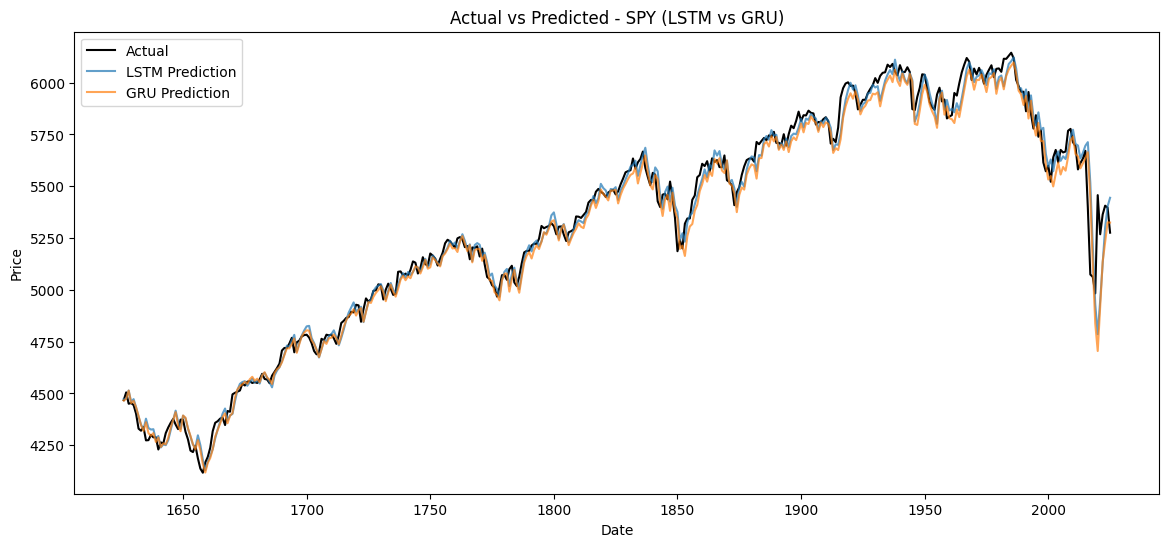

In [133]:
ticker = 'SPY'
plt.figure(figsize=(14,6))
plt.plot(dates, y_test_actual, label='Actual', color='black')
plt.plot(dates, pred_lstm, label='LSTM Prediction', alpha=0.7)
plt.plot(dates, pred_gru, label='GRU Prediction', alpha=0.7)
plt.title(f'Actual vs Predicted - {ticker} (LSTM vs GRU)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(False)
plt.show()

### Add external other financial instruments as features

In [129]:
print(SPY.columns.to_list())
#SPY['^VIX'].head()
all_features = SPY.columns.to_list() # test all of the features 

['ds', 'SPY_Close', 'SPY_Volume', 'AAPL', 'MSFT', 'GOOG', 'GLD', 'SLV', '^TNX', 'DX-Y.NYB', 'JPY=X', 'EUR=X', 'USO', 'UNG', 'BTC-USD', 'CPER', '^VIX', '^GDAXI', '^FTSE', '^RUT', '^N225', 'IEI', 'CNYUSD=X', '2Y_Yield', 'yield_curve', 'market_closed_count', 'yield_curve_term', 'high-low', 'before_high-low', 'SPY_RSI', 'RSI_rank', 'RSI_rank_2', 'EMA_20', 'EMA_50', 'EMA_200', 'EMA_20_50', 'EMA_50_200', 'EMA_50_diff', 'EMA_200_diff', 'SPY_std', 'SPY_mean', 'SPY_30', 'QQQ_Close', 'QQQ_Volume', 'qqq_std', 'qqq_mean']


In [197]:
col_list = []
result2 = model_own_features(
    data=SPY,
    column='SPY_Close',
    keep_columns=['SPY_Close','high-low','before_high-low','SPY_Volume','QQQ_Close','CPER','^VIX','^RUT','yield_curve','EMA_50', 'EMA_200','IEI','^GDAXI', '^FTSE','DX-Y.NYB', 'JPY=X', 'EUR=X', 'USO','ds']
)

result2['abs_consecutive_change'] = calculate_consecutive_return(result2['SPY_Close'], result2['streak'])
result2 = date_features(result2) # to add date features
result2 = result2.merge(spy_zones[['ds','SUPPORT_Signal','RESISTANCE_Signal']], on='ds', how='left') # optional : add support and resistance areas
result2 = result2.drop('ds', axis=1) # drop the date column
result2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SPY_Close               2036 non-null   float64
 1   high-low                2036 non-null   float64
 2   before_high-low         2036 non-null   float64
 3   SPY_Volume              2036 non-null   int64  
 4   QQQ_Close               2036 non-null   float64
 5   CPER                    2036 non-null   float64
 6   ^VIX                    2036 non-null   float64
 7   ^RUT                    2036 non-null   float64
 8   yield_curve             2036 non-null   float64
 9   EMA_50                  2036 non-null   float64
 10  EMA_200                 2036 non-null   float64
 11  IEI                     2036 non-null   float64
 12  ^GDAXI                  2036 non-null   float64
 13  ^FTSE                   2036 non-null   float64
 14  DX-Y.NYB                2036 non-null   

### prepare the data

In [198]:
window_size = 30
X_train, X_test, y_train, y_test,X = prepare_RNN_data(result, 30,scaler)

### Search for the best hyperparameters 

### GRU

In [203]:
best_model, best_loss, best_cfg = search_best_model(
    model_type="GRU",                # or "LSTM"
    X_train=X_train, y_train=y_train,
    X_val=X_test,  y_val=y_test,
    window_size=window_size, # None since we reshape to (samples, 1, features)
    layer_options=[1,2,3],
    unit_options=[32,64,92],
    epochs=25,
    batch_size=32,
    patience=5,
    learning_rates=(0.005,0.004),
    dense_units = None,
    dense_activation='relu',
    dropout_rate=0.1
)
print("Best loss:", best_loss, "Config:", best_cfg)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best loss: 0.0003068161604460329 Config: {'model_type': 'GRU', 'n_layers': 1, 'units': (64,), 'learning_rate': 0.005, 'dense_units': None, 'dense_activation': 'relu', 'dropout_rate': 0.1}


### train the models

Epoch 1/30


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0558
Epoch 1: val_loss improved from inf to 0.00052, saving model to best_gru_with_feat.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0538 - val_loss: 5.1654e-04
Epoch 2/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0021
Epoch 2: val_loss improved from 0.00052 to 0.00049, saving model to best_gru_with_feat.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0021 - val_loss: 4.9180e-04
Epoch 3/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0013
Epoch 3: val_loss improved from 0.00049 to 0.00039, saving model to best_gru_with_feat.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0013 - val_loss: 3.8657e-04
Epoch 4/30
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0012
Epoch 4: val_loss improved from 0.00039 to 0.00023, saving model to best_gru_with_feat.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0012 - val_loss: 2.2903e-04
Epoch 5/30
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0010
Epoch 5: val_loss improved from 0.00023 to 0.00018, saving model to best_gru_with_feat.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0010 - val_loss: 1.8110e-04
Epoch 6/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.3604e-04
Epoch 6: val_loss did not improve from 0.00018
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 6.3515e-04 - val_loss: 3.6850e-04
Epoch 7/30
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.1685e-04
Epoch 7: val_loss improved from 0.00018 to 0.00013, saving model to best_gru_with_feat.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 8.0623e-04 - val_loss: 1.3027e-04
Epoch 8/30
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.2104e-04
Epoch 8: val_loss improved from 0.00013 to 0.00012, saving model to best_gru_with_feat.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 6.1850e-04 - val_loss: 1.1633e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.4333e-04
Epoch 9: val_loss did not improve from 0.00012
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 5.4311e-04 - val_loss: 3.6707e-04
Epoch 10/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.8193e-04
Epoch 10: val_loss did not improve from 0.00012
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 5.8067e-04 - val_loss: 1.3796e-04
Epoch 11/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.3637e-04
Epoch 11: val_loss improved from 0.00012 to 0.00011, saving model to best_gru_with_feat.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 5.3517e-04 - val_loss: 1.1497e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.5106e-04
Epoch 12: val_loss did not improve from 0.00011
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5.5007e-04 - val_loss: 4.2432e-04
Epoch 13/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.0221e-04
Epoch 13: val_loss did not improve from 0.00011
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 5.0078e-04 - val_loss: 1.7713e-04
Epoch 14/30
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.3661e-04
Epoch 14: val_loss improved from 0.00011 to 0.00011, saving model to best_gru_with_feat.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.3755e-04 - val_loss: 1.0822e-04
Epoch 15/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.6800e-04
Epoch 15: val_loss did not improve from 0.00011
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.6706e-04 - val_loss: 1.2192e-04
Epoch 16/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.3220e-04
Epoch 16: val_loss did not improve from 0.00011
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.3064e-04 - val_loss: 2.7213e-04
Epoch 17/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.6660e-04
Epoch 17: val_loss did not improve from 0.00011
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.6624e-04 - val_loss: 2.2706e-04
Epoch 18/30
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.6966e-04
Epoch 18: val_loss did not improve from 0.00011
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.6817e-04 - val_loss: 1.2009e-04
Epoch 19/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.0907e-04
Epoch 19: val_loss did not improve from 0.0

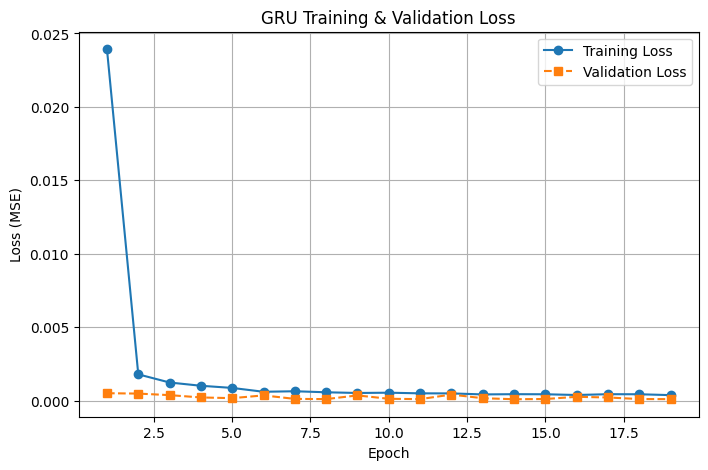

In [210]:
model_gru , history= train_gru(
    X_train, y_train,
    learning_rate=0.005,
    epochs=30,
    num_layers=1,
    units=(92,),
    window_size=window_size,
    batch_size=32,
    validation_split=0.1,
    patience=5,
    checkpoint_path='best_gru_with_feat.h5',
    dense_units=None,
    dense_activation='relu',
    dropout_rate=0.1
    
)

# 2) Plot
plot_training_history(history, title="GRU Training & Validation Loss")

### LSTM

In [55]:
best_model, best_loss, best_cfg = search_best_model(
    model_type="LSTM",                # or "LSTM"
    X_train=X_train, y_train=y_train,
    X_val=X_test,  y_val=y_test,
    window_size=window_size, # None since we reshape to (samples, 1, features)
    layer_options=[1,2,3],
    unit_options=[32,64,92],
    epochs=25,
    batch_size=32,
    patience=3,
    learning_rates=(0.004,),
    dense_units = None,
    dense_activation='relu',
    dropout_rate=None
)
print("Best loss:", best_loss, "Config:", best_cfg)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

In [137]:
model_lstm = train_lstm(
    X_train, y_train,
    learning_rate=0.004,
    epochs=30,
    num_layers=1,
    units=(64,),
    window_size=window_size,
    batch_size=32,
    validation_split=0.1,
    patience=5,
    checkpoint_path='best_lstm_with_feat.h5',
    dense_units=None,
    dense_activation='relu',
    dropout_rate=None
)[0]

Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0270
Epoch 1: val_loss improved from inf to 0.00099, saving model to best_lstm_with_feat.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0267 - val_loss: 9.8557e-04
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6461e-04
Epoch 2: val_loss improved from 0.00099 to 0.00013, saving model to best_lstm_with_feat.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.6257e-04 - val_loss: 1.3489e-04
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6193e-04
Epoch 3: val_loss improved from 0.00013 to 0.00013, saving model to best_lstm_with_feat.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.6192e-04 - val_loss: 1.3397e-04
Epoch 4/30
41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3482e-04
Epoch 4: val_loss did not improve from 0.00013
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3562e-04 - val_loss: 1.4263e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9847e-04
Epoch 5: val_loss did not improve from 0.00013
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.9894e-04 - val_loss: 1.5612e-04
Epoch 6/30
41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5098e-04
Epoch 6: val_loss improved from 0.00013 to 0.00013, saving model to best_lstm_with_feat.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.4878e-04 - val_loss: 1.3010e-04
Epoch 7/30
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8726e-04
Epoch 7: val_loss improved from 0.00013 to 0.00012, saving model to best_lstm_with_feat.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.8781e-04 - val_loss: 1.2038e-04
Epoch 8/30
41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0988e-04
Epoch 8: val_loss did not improve from 0.00012
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0969e-04 - val_loss: 2.0900e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0279e-04
Epoch 9: val_loss did not improve from 0.00012
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0155e-04 - val_loss: 1.2847e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0394e-04
Epoch 10: val_loss did not improve from 0.00012
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.0380e-04 - val_loss: 1.2567e-04
Epoch 11/30
41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7173e-04
Epoch 11: val_loss did not improve from 0.00012
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7230e-04 - val_loss: 2.4532e-04
Epoch 12/30
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0080e-04
Epoch 12: val_loss improved from 0.00012 to 0.0

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.9961e-04 - val_loss: 1.1091e-04
Epoch 13/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7757e-04
Epoch 13: val_loss did not improve from 0.00011
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7744e-04 - val_loss: 1.4451e-04
Epoch 14/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5874e-04
Epoch 14: val_loss did not improve from 0.00011
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.5894e-04 - val_loss: 1.4262e-04
Epoch 15/30
41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4392e-04
Epoch 15: val_loss did not improve from 0.00011
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4601e-04 - val_loss: 2.0236e-04
Epoch 16/30
41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8911e-04
Epoch 16: val_loss improved from 0.00011 to 0.00011, saving model to best_lstm_with_feat.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.8723e-04 - val_loss: 1.0831e-04
Epoch 17/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5451e-04
Epoch 17: val_loss did not improve from 0.00011
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5449e-04 - val_loss: 2.9404e-04
Epoch 18/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1485e-04
Epoch 18: val_loss did not improve from 0.00011
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.1420e-04 - val_loss: 2.7798e-04
Epoch 19/30
41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0069e-04
Epoch 19: val_loss did not improve from 0.00011
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9606e-04 - val_loss: 1.1329e-04
Epoch 20/30
41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3662e-04
Epoch 20: val_loss did not improve from 0.00011
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.3792e-04 - val_loss: 1.2560e-04
Epoch 21/30
41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3299e-04
Epoch 21: val_loss did not improve from 0.0

### 2 **Check the models with addea features**

In [211]:
abs_result = evaluate_models_with_price_scaler(
    model_lstm=model_lstm,
    model_gru=model_gru,
    X_test=X_test,
    y_test=y_test,
    scaler=scaler
)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
LSTM - MSE: 14884.0499, R²: 0.9504
GRU  - MSE: 6561.1895, R²: 0.9781


In [209]:
preds, model = load_best_model('best_gru_with_feat.h5')

preds_lstm, model_lstm = load_best_model('best_lstm_with_feat.h5')
# print the metrics of the best model 
gru_mse = mean_squared_error(y_test, preds)
gru_r2 = r2_score(y_test, preds)

lstm_mse = mean_squared_error(y_test, preds_lstm)
lstm_r2 = r2_score(y_test, preds_lstm)

print(f'GRU - MSE: {gru_mse:.4f}, R²: {gru_r2:.4f}')
print(f'LSTM - MSE: {lstm_mse:.4f}, R²: {lstm_r2:.4f}')

TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

# Add external data (economic data)

In [85]:
external_data = pd.read_pickle('external_data.pkl')
external_data.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2592 non-null   datetime64[ns]
 1   Actual_GDP                     204 non-null    float64       
 2   Actual_nonfarm                 206 non-null    float64       
 3   Actual_CPI                     155 non-null    float64       
 4   Actual_PPI                     170 non-null    float64       
 5   Actual_unemployment rate       201 non-null    float64       
 6   Actual_core_PCE                125 non-null    float64       
 7   Actual_FOMC                    139 non-null    float64       
 8   CPI_vs_forecast                155 non-null    float64       
 9   CPI_vs_previous                155 non-null    float64       
 10  GDP_vs_forecast                204 non-null    float64       
 11  GDP_vs_previous  

In [87]:
#external_data.iloc[145:155]
external_data.fillna(method='ffill', inplace=True)
external_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2592 non-null   datetime64[ns]
 1   Actual_GDP                     2592 non-null   float64       
 2   Actual_nonfarm                 2591 non-null   float64       
 3   Actual_CPI                     2443 non-null   float64       
 4   Actual_PPI                     2499 non-null   float64       
 5   Actual_unemployment rate       2580 non-null   float64       
 6   Actual_core_PCE                2308 non-null   float64       
 7   Actual_FOMC                    2590 non-null   float64       
 8   CPI_vs_forecast                2443 non-null   float64       
 9   CPI_vs_previous                2443 non-null   float64       
 10  GDP_vs_forecast                2592 non-null   float64       
 11  GDP_vs_previous  

C:\Users\OMER\AppData\Local\Temp\ipykernel_42572\2534430223.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  external_data.fillna(method='ffill', inplace=True)


In [220]:
# print to see all of the data available 
lst_ = external_data.columns.to_list()
l = [col for col in lst_ if col.endswith('vs_forecast')]
print(l)
print(lst_[7:15])

['CPI_vs_forecast', 'GDP_vs_forecast', 'PPI_vs_forecast', 'nonfarm_vs_forecast', 'unemployment rate_vs_forecast', 'core_PCE_vs_forecast', 'FOMC_vs_forecast']
['Actual_FOMC', 'CPI_vs_forecast', 'CPI_vs_previous', 'GDP_vs_forecast', 'GDP_vs_previous', 'PPI_vs_forecast', 'PPI_vs_previous', 'nonfarm_vs_forecast']


### Prepare the new data for modeling

In [221]:
col_list = ['SPY_Close','high-low','before_high-low','SPY_Volume','QQQ_Close','CPER','^VIX','^RUT','yield_curve','EMA_50', 'EMA_200','IEI','^GDAXI', '^FTSE','DX-Y.NYB', 'JPY=X', 'EUR=X', 'USO','ds']
ext_cols = l#lst_[7:15]
ext_cols.append('ds') # add the date column
result3 = model_own_features(data= SPY , column='SPY_Close', keep_columns=col_list)
# Now merge 
result3 = result3.merge(external_data[ext_cols], on='ds', how='left')
result3 = result3.drop('ds',axis=1) # drop the date column
result3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2038 entries, 0 to 2037
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SPY_Close                      2038 non-null   float64
 1   high-low                       2038 non-null   float64
 2   before_high-low                2038 non-null   float64
 3   SPY_Volume                     2038 non-null   int64  
 4   QQQ_Close                      2038 non-null   float64
 5   CPER                           2038 non-null   float64
 6   ^VIX                           2038 non-null   float64
 7   ^RUT                           2038 non-null   float64
 8   yield_curve                    2038 non-null   float64
 9   EMA_50                         2038 non-null   float64
 10  EMA_200                        2038 non-null   float64
 11  IEI                            2038 non-null   float64
 12  ^GDAXI                         2038 non-null   f

In [222]:
window_size = 30
X_train, X_test, y_train, y_test,X = prepare_RNN_data(result3, 30,scaler)

In [223]:
best_model, best_loss, best_cfg = search_best_model(
    model_type="GRU",                # or "LSTM"
    X_train=X_train, y_train=y_train,
    X_val=X_test,  y_val=y_test,
    window_size=window_size, # None since we reshape to (samples, 1, features)
    layer_options=[1,2,3],
    unit_options=[32,64,92],
    epochs=25,
    batch_size=32,
    patience=5,
    learning_rates=(0.004,0.003),
    dense_units = None,
    dense_activation='relu',
    dropout_rate=0.1
)
print("Best loss:", best_loss, "Config:", best_cfg)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best loss: 0.0010562548413872719 Config: {'model_type': 'GRU', 'n_layers': 1, 'units': (32,), 'learning_rate': 0.004, 'dense_units': None, 'dense_activation': 'relu', 'dropout_rate': 0.1}


Epoch 1/30


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0955
Epoch 1: val_loss improved from inf to 0.03136, saving model to best_gru_with_external.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0935 - val_loss: 0.0314
Epoch 2/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0111
Epoch 2: val_loss improved from 0.03136 to 0.00909, saving model to best_gru_with_external.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0110 - val_loss: 0.0091
Epoch 3/30
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0056
Epoch 3: val_loss improved from 0.00909 to 0.00674, saving model to best_gru_with_external.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0056 - val_loss: 0.0067
Epoch 4/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0048
Epoch 4: val_loss improved from 0.00674 to 0.00214, saving model to best_gru_with_external.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 5/30
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0041
Epoch 5: val_loss did not improve from 0.00214
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0041 - val_loss: 0.0048
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0033
Epoch 6: val_loss improved from 0.00214 to 0.00169, saving model to best_gru_with_external.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 7/30
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0026
Epoch 7: val_loss improved from 0.00169 to 0.00047, saving model to best_gru_with_external.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0026 - val_loss: 4.6952e-04
Epoch 8/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0022
Epoch 8: val_loss did not improve from 0.00047
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 9/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0024
Epoch 9: val_loss did not improve from 0.00047
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0023 - val_loss: 0.0038
Epoch 10/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0017
Epoch 10: val_loss did not improve from 0.00047
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 11/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016
Epoch 11: val_loss improved from 0.00047 to 0.00041, saving model to best_gru_with_external.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015 - val_loss: 4.0722e-04
Epoch 12/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0017
Epoch 12: val_loss did not improve from 0.00041
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 13/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0014
Epoch 13: val_loss did not improve from 0.00041
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014 - val_loss: 4.2149e-04
Epoch 14/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012
Epoch 14: val_loss did not improve from 0.00041
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 15/30
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0010
Epoch 15: val_loss did not improve from 0.00041
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 16/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012
Epoch 16: val_loss did not improve from 0.00041
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss:

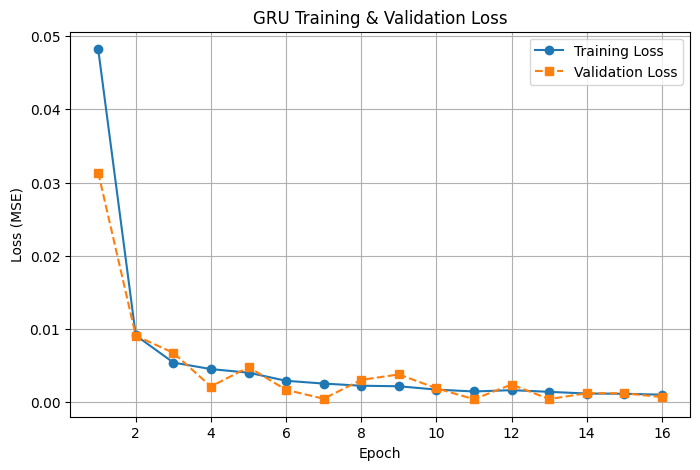

In [216]:
model_gru , history= train_gru(
    X_train, y_train,
    learning_rate=0.004,
    epochs=30,
    num_layers=1,
    units=(32,),
    window_size=window_size,
    batch_size=32,
    validation_split=0.1,
    patience=5,
    checkpoint_path='best_gru_with_external.h5',
    dense_units=None,
    dense_activation='relu',
    dropout_rate=0.1
)

# 2) Plot
plot_training_history(history, title="GRU Training & Validation Loss")

In [ ]:
best_model, best_loss, best_cfg = search_best_model(
    model_type="LSTM",                # or "LSTM"
    X_train=X_train, y_train=y_train,
    X_val=X_test,  y_val=y_test,
    window_size=window_size, # None since we reshape to (samples, 1, features)
    layer_options=[1,2,3],
    unit_options=[32,64,92],
    epochs=25,
    batch_size=32,
    patience=5,
    learning_rates=(0.003,),
    dense_units = None,
    dense_activation='relu',
    dropout_rate=0.1
)
print("Best loss:", best_loss, "Config:", best_cfg)

In [217]:
model_lstm = train_lstm(
    X_train, y_train,
    learning_rate=0.004,
    epochs=30,
    num_layers=1,
    units=(64,),
    window_size=window_size,
    batch_size=32,
    validation_split=0.1,
    patience=5,
    checkpoint_path='best_lstm_with_external.h5',
    dense_units=None,
    dense_activation='relu',
    dropout_rate=None
)[0]

Epoch 1/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0503
Epoch 1: val_loss improved from inf to 0.01122, saving model to best_lstm_with_external.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0493 - val_loss: 0.0112
Epoch 2/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0452
Epoch 2: val_loss improved from 0.01122 to 0.00944, saving model to best_lstm_with_external.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0443 - val_loss: 0.0094
Epoch 3/30
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0231
Epoch 3: val_loss improved from 0.00944 to 0.00115, saving model to best_lstm_with_external.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0224 - val_loss: 0.0012
Epoch 4/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0224
Epoch 4: val_loss did not improve from 0.00115
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0219 - val_loss: 0.0033
Epoch 5/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0253
Epoch 5: val_loss did not improve from 0.00115
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0247 - val_loss: 0.0046
Epoch 6/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0110
Epoch 6: val_loss did not improve from 0.00115
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0108 - val_loss: 0.0072
Epoch 7/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0070
Epoch 7: val_loss did not improve from 0.00115
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0070 - val_loss: 0.0051
Epoch 8/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0173
Epoch 8: val_loss did not improve from 0.00115
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0170 - val_loss

In [218]:
abs_result = evaluate_models_with_price_scaler(
    model_lstm=model_lstm,
    model_gru=model_gru,
    X_test=X_test,
    y_test=y_test,
    scaler=scaler
)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
LSTM - MSE: 993589.0234, R²: -2.3118
GRU  - MSE: 84905.8412, R²: 0.7170


# **Forcasting return data**

In [108]:
return_data = pd.read_pickle('df_with_QQQ.pkl')
return_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 47 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   QQQ_Close        2071 non-null   float64       
 1   ^RUT             2071 non-null   float64       
 2   ^VIX             2071 non-null   float64       
 3   EMA_20           2071 non-null   float64       
 4   ^GDAXI           2071 non-null   float64       
 5   MSFT             2071 non-null   float64       
 6   stdev_5          2071 non-null   float64       
 7   ^FTSE            2071 non-null   float64       
 8   GOOG             2071 non-null   float64       
 9   AAPL             2071 non-null   float64       
 10  high-low         2071 non-null   float64       
 11  avgreturn5d      2071 non-null   float64       
 12  abs_yield_curve  2071 non-null   float64       
 13  std_price        2071 non-null   float64       
 14  UNG              2071 non-null   float64

In [109]:
print(return_data.columns.to_list())
return_data = return_data.reindex(columns=["SPY_return"] + list(return_data.columns.drop("SPY_return")))

['QQQ_Close', '^RUT', '^VIX', 'EMA_20', '^GDAXI', 'MSFT', 'stdev_5', '^FTSE', 'GOOG', 'AAPL', 'high-low', 'avgreturn5d', 'abs_yield_curve', 'std_price', 'UNG', 'abs_vix', 'SLV', 'stdev', 'BTC-USD', 'EMA_50', 'EMA_200', '^TNX', 'USO', 'IWM_avg5d', 'shiler pe', 'JPY=X', 'GLD', 'SPY_AbsChange', 'SPY_Volume', '^N225', 'CPER', 'CNYUSD=X', 'before_high-low', 'abs_vol', 'IWM_std_5d', 'yield_curve', 'IEI', 'DX-Y.NYB', 'EUR=X', 'avgreturn10d', '2Y_Yield', 'EUR', 'SPY_RSI', 'DXY', 'JPY', 'ds', 'SPY_return']


### Add MACD data

In [130]:
result1 = model_own_features(
    data=SPY,
    column='SPY_Close',
    keep_columns=['SPY_Close','high-low','before_high-low','ds']
)

In [131]:
return_data1 = return_data.merge(result1[['ds','MACD']], on='ds', how='inner')

# Add features for seasonality 

In [236]:

return_data1['month'] = return_data1['ds'].dt.month
return_data1['day_of_week'] = return_data1['ds'].dt.dayofweek
return_data1['day_of_week'] = return_data1['day_of_week'] + 2
return_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2026 entries, 0 to 2025
Data columns (total 50 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   SPY_return       2026 non-null   float64       
 1   QQQ_Close        2026 non-null   float64       
 2   ^RUT             2026 non-null   float64       
 3   ^VIX             2026 non-null   float64       
 4   EMA_20           2026 non-null   float64       
 5   ^GDAXI           2026 non-null   float64       
 6   MSFT             2026 non-null   float64       
 7   stdev_5          2026 non-null   float64       
 8   ^FTSE            2026 non-null   float64       
 9   GOOG             2026 non-null   float64       
 10  AAPL             2026 non-null   float64       
 11  high-low         2026 non-null   float64       
 12  avgreturn5d      2026 non-null   float64       
 13  abs_yield_curve  2026 non-null   float64       
 14  std_price        2026 non-null   float64

In [238]:
#x1 = return_data.drop(columns=['SPY_return','ds'])
#y1 = return_data['SPY_return']
cols = ['SPY_return', 'QQQ_Close', '^RUT', 'abs_vix','MSFT', 'stdev_5', '^FTSE', 'GOOG', 'AAPL', 'high-low', 'avgreturn5d', 'abs_yield_curve', 'std_price','SPY_AbsChange','abs_vol','2Y_Yield','EUR', 'SPY_RSI', 'DXY', 'JPY','month','day_of_week' ]
inner_cols = ['SPY_return','stdev_5','high-low','std_price','SPY_AbsChange','abs_vol','SPY_RSI','EMA_20','MACD','month','day_of_week'] # the inner instruments features

return_data_own_feat = return_data1[inner_cols] # create a df with only the inner instruments features



In [ ]:
for x in inner_cols:
    if x not in cols:
        cols.append(x)

print(cols)



['SPY_return', 'QQQ_Close', '^RUT', 'abs_vix', 'MSFT', 'stdev_5', '^FTSE', 'GOOG', 'AAPL', 'high-low', 'avgreturn5d', 'abs_yield_curve', 'std_price', 'SPY_AbsChange', 'abs_vol', '2Y_Yield', 'EUR', 'SPY_RSI', 'DXY', 'JPY', 'EMA_20', 'MACD']


In [ ]:
#return_1.head()
return_data1.head()

,SPY_return,stdev_5,high-low,std_price,SPY_AbsChange,abs_vol,SPY_RSI,EMA_20,MACD
0,0.725147,0.358121,26.150146,17.616534,-0.292102,3369120000,47.955152,0.005353,-2.163017
1,0.108532,0.356293,10.420166,15.284525,0.725147,3107670000,48.276382,0.015185,-1.700607
2,0.293511,0.340680,11.839844,13.461341,0.834467,3159680000,47.892270,0.041730,-0.766106
3,-0.225505,0.373196,7.750000,11.390325,1.130427,3356740000,45.208163,0.016178,-0.451207
4,-0.164213,0.384971,21.140137,9.509412,-0.225505,3418730000,46.940722,-0.001028,-0.508855


## Preparing the data 

In [250]:

from sklearn.preprocessing import RobustScaler

def prepare_sequence_data(df, columns, window_size, target,test_size=0.1):
    """
    Prepares sequence data for time-series modeling.

    Parameters
    ----------
    df : pandas.DataFrame
        Original DataFrame containing at least the columns in `columns`.
    columns : list of str
        List of column names to keep. The first column in this list is treated as the target.
    window_size : int
        Number of lagged periods to create for the target column.
    test_size : float
        Fraction of the data to reserve for testing (between 0 and 1).

    Returns
    -------
    X_train, X_test : np.ndarray
        Features shaped (n_samples, 1, n_features).
    y_train, y_test : np.ndarray
        Targets shaped (n_samples, 1).
    scaler_X, scaler_y : RobustScaler
        Fitted scalers for features and target.
    """
    # 1) Select only the desired columns
    data = df[columns].copy()
    
    # 2) Create lagged features for the target
    for i in range(1, window_size + 1):
        data[f"{target}_lag_{i}"] = data[target].shift(i)
    
    # 3) Drop rows with NaNs from lagging
    data = data.dropna()
    
    # 4) Split into X and y
    X = data.drop(columns=[target]).values
    y = data[target].values.reshape(-1, 1)
    
    # 5) Scale features and target
    scaler_X = RobustScaler().fit(X)
    scaler_y = RobustScaler().fit(y)
    X_scaled = scaler_X.transform(X)
    y_scaled = scaler_y.transform(y)
    
    # 6) Reshape X for LSTM/GRU input: (samples, timesteps=1, features)
    X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
    
    # 7) Train-test split
    split_idx = int((1 - test_size) * len(X_scaled))
    X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
    y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]
    
    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

# Example usage:
# cols = ['SPY_return', 'abs_vix', 'abs_vol']
# X_train, X_test, y_train, y_test, scaler_X, scaler_y = prepare_sequence_data(return_data1, cols, window_size=5, test_size=0.1)


In [251]:
X_train, X_test, y_train, y_test, scaler_X, scaler_y = prepare_sequence_data(return_data1, inner_cols, 5, 'SPY_return',test_size=0.1)

In [ ]:
# Now with extended features :
X_train_ext, X_test_ext, y_train_ext, y_test_ext, scaler_X_ext, scaler_y_ext = prepare_sequence_data(
    return_data1, cols, 5, 'SPY_return', test_size=0.1
)

## Search for the best params

In [319]:
best_model, best_loss, best_cfg = search_best_model(
    model_type="GRU",                # or "LSTM"
    X_train=X_train, y_train=y_train,
    X_val=X_test,  y_val=y_test,
    window_size=None, # None since we reshape to (samples, 1, features)
    layer_options=[1,2,3],
    unit_options=[32,64,96],
    epochs=25,
    batch_size=32,
    patience=3,
    learning_rates=(0.005,0.0025),
    dense_units = None,
    dense_activation='relu',
    dropout_rate=0.1
)
print("Best loss:", best_loss, "Config:", best_cfg)


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best loss: 0.2528541386127472 Config: {'model_type': 'GRU', 'n_layers': 1, 'units': (32,), 'learning_rate': 0.005, 'dense_units': None, 'dense_activation': 'relu', 'dropout_rate': 0.1}


In [283]:
best_model, best_loss, best_cfg = search_best_model(
    model_type="LSTM",                # or "LSTM"
    X_train=X_train, y_train=y_train,
    X_val=X_test,  y_val=y_test,
    window_size=None,
    layer_options=[1,2,3],
    unit_options=[32,64,92],
    epochs=25,
    batch_size=32,
    patience=3,
    learning_rates=(0.005, 0.0025),
    dense_units=None,
    dense_activation='relu',
    dropout_rate=0.1 # None for no dropout
)
print("Best loss:", best_loss, "Config:", best_cfg)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best loss: 0.2361878603696823 Config: {'model_type': 'LSTM', 'n_layers': 3, 'units': (32, 32, 92), 'learning_rate': 0.005, 'dense_units': None, 'dense_activation': 'relu', 'dropout_rate': 0.1}


### LSTM

In [ ]:
model_lstm = train_lstm(
    X_train, y_train,
    learning_rate=0.005,
    epochs=30,
    num_layers=3,
    units=(32, 32, 92),
    window_size=1,
    batch_size=None,
    validation_split=0.1,
    patience=5,
    checkpoint_path='best_return_lstm.h5',
    dense_units=None,
    dense_activation='relu',
    dropout_rate=0.1
)[0]

Epoch 1/30


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3741
Epoch 1: val_loss improved from inf to 0.36056, saving model to best_return_lstm.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.3741 - val_loss: 0.3606
Epoch 2/30
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6629
Epoch 2: val_loss improved from 0.36056 to 0.29904, saving model to best_return_lstm.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6580 - val_loss: 0.2990
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4797
Epoch 3: val_loss did not improve from 0.29904
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4783 - val_loss: 0.3160
Epoch 4/30
42/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3366
Epoch 4: val_loss improved from 0.29904 to 0.24695, saving model to best_return_lstm.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3330 - val_loss: 0.2470
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2634
Epoch 5: val_loss did not improve from 0.24695
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2636 - val_loss: 0.3011
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2656
Epoch 6: val_loss improved from 0.24695 to 0.20896, saving model to best_return_lstm.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2658 - val_loss: 0.2090
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2411
Epoch 7: val_loss improved from 0.20896 to 0.16811, saving model to best_return_lstm.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2408 - val_loss: 0.1681
Epoch 8/30
39/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1806
Epoch 8: val_loss did not improve from 0.16811
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1886 - val_loss: 0.1761
Epoch 9/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2827
Epoch 9: val_loss did not improve from 0.16811
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2821 - val_loss: 0.2187
Epoch 10/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1880
Epoch 10: val_loss did not improve from 0.16811
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1880 - val_loss: 0.2023
Epoch 11/30
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1913
Epoch 11: val_loss improved from 0.16811 to 0.12395, saving model to best_return_lstm.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1906 - val_loss: 0.1239
Epoch 12/30
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1461
Epoch 12: val_loss did not improve from 0.12395
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1472 - val_loss: 0.1271
Epoch 13/30
40/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2303
Epoch 13: val_loss did not improve from 0.12395
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2283 - val_loss: 0.1548
Epoch 14/30
41/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1677
Epoch 14: val_loss did not improve from 0.12395
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1686 - val_loss: 0.1993
Epoch 15/30
40/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1780
Epoch 15: val_loss did not improve from 0.12395
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1737 - val_loss: 0.2096
Epoch 16/30
42/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1634
Epoch 16: val_loss did not improve from 0.12395
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1632 - val_loss:

### GRU

In [321]:
model_gru = train_gru(
    X_train, y_train,
    learning_rate=0.005,
    epochs=30,
    num_layers=1,
    units=(32,),
    window_size=None,
    batch_size=32,
    validation_split=0.1,
    patience=5,
    checkpoint_path='best_return_gru.h5',
    dense_units=None,
    dense_activation='relu',
    dropout_rate=0.1
)[0] 

Epoch 1/30


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3804  
Epoch 1: val_loss improved from inf to 0.25440, saving model to best_return_gru.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3465 - val_loss: 0.2544
Epoch 2/30
39/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7524
Epoch 2: val_loss did not improve from 0.25440
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7422 - val_loss: 0.2601
Epoch 3/30
38/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4169
Epoch 3: val_loss did not improve from 0.25440
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4260 - val_loss: 0.2852
Epoch 4/30
38/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2798
Epoch 4: val_loss did not improve from 0.25440
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2911 - val_loss: 0.2841
Epoch 5/30
41/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2921
Epoch 5: val_loss did not improve from 0.25440
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2879 - val_loss: 0.2898
Epoch 6/30
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2529
Epoch 6: val_loss improved from 0.25440 to 0.18944, saving model to best_return_gru.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2526 - val_loss: 0.1894
Epoch 7/30
40/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2026
Epoch 7: val_loss did not improve from 0.18944
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2056 - val_loss: 0.2122
Epoch 8/30
40/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2116
Epoch 8: val_loss improved from 0.18944 to 0.15319, saving model to best_return_gru.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2183 - val_loss: 0.1532
Epoch 9/30
40/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2826
Epoch 9: val_loss did not improve from 0.15319
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2692 - val_loss: 0.1773
Epoch 10/30
35/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1813
Epoch 10: val_loss did not improve from 0.15319
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1932 - val_loss: 0.1635
Epoch 11/30
38/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1904
Epoch 11: val_loss did not improve from 0.15319
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1933 - val_loss: 0.1577
Epoch 12/30
36/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1792
Epoch 12: val_loss did not improve from 0.15319
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1864 - val_loss: 0.2062
Epoch 13/30
39/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1852
Epoch 13: val_loss improved from 0.15319 to 0.14035, saving model to best_return_gru.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1851 - val_loss: 0.1403
Epoch 14/30
37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1827
Epoch 14: val_loss did not improve from 0.14035
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1780 - val_loss: 0.2242
Epoch 15/30
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1754
Epoch 15: val_loss did not improve from 0.14035
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1750 - val_loss: 0.2011
Epoch 16/30
37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1918
Epoch 16: val_loss did not improve from 0.14035
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1868 - val_loss: 0.1537
Epoch 17/30
41/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1877
Epoch 17: val_loss did not improve from 0.14035
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1863 - val_loss: 0.1406
Epoch 18/30
36/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1922
Epoch 18: val_loss did not improve from 0.14035
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1901 - val_loss:

### Creating a sequence as features & split the data 

In [ ]:
# Scaling
#scaler_X, scaler_y = RobustScaler(), RobustScaler()
#X_scaled = scaler_X.fit_transform(x1)
#y_scaled = scaler_y.fit_transform(y1.values.reshape(-1, 1))
#X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Split data
#split_index = int(0.9 * len(X_scaled))
#X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
#y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]
#train_dates, test_dates = dates[:split_index], dates[split_index:]

In [249]:

def evaluate_models(model_gru, model_lstm, X_test, y_test, scaler_y):
    """
    Predicts with both GRU and LSTM models, inverse-transforms the predictions and true values,
    computes MSE and R² for each, prints the results, and returns them in a dict.

    Parameters:
    - model_gru: trained GRU Keras model
    - model_lstm: trained LSTM Keras model
    - X_test: np.ndarray of test features shaped (n_samples, timesteps, features)
    - y_test: np.ndarray of test targets (scaled) shaped (n_samples, 1)
    - scaler_y: fitted RobustScaler (or any scaler) for the target

    Returns:
    - results: dict with keys 'mse_gru', 'r2_gru', 'mse_lstm', 'r2_lstm'
    """
    # 1) Predictions
    pred_gru = model_gru.predict(X_test)
    pred_lstm = model_lstm.predict(X_test)
    
    # 2) Inverse transform
    y_pred_gru = scaler_y.inverse_transform(pred_gru)
    y_pred_lstm = scaler_y.inverse_transform(pred_lstm)
    y_true = scaler_y.inverse_transform(y_test)
    
    # 3) Metrics
    mse_gru = mean_squared_error(y_true, y_pred_gru)
    r2_gru = r2_score(y_true, y_pred_gru)
    mse_lstm = mean_squared_error(y_true, y_pred_lstm)
    r2_lstm = r2_score(y_true, y_pred_lstm)
    
    # 4) Print
    print(f'GRU  - MSE: {mse_gru:.4f}, R²: {r2_gru:.4f}')
    print(f'LSTM - MSE: {mse_lstm:.4f}, R²: {r2_lstm:.4f}')
    
    # 5) Return results
    return {
        'mse_gru': mse_gru,
        'r2_gru': r2_gru,
        'mse_lstm': mse_lstm,
        'r2_lstm': r2_lstm
    }





In [323]:
results = evaluate_models(model_gru, model_lstm, X_test, y_test, scaler_y)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
GRU  - MSE: 0.3986, R²: 0.7625
LSTM - MSE: 0.3297, R²: 0.8036


GRU  - MSE: 0.3206, R²: 0.8090
LSTM - MSE: 0.3297, R²: 0.8036

# Now I will add more features 

In [ ]:
# A function to shift data by a specified number of periods for multiple columns
def shift_data(df,columns,shift):
    for col in columns:
        for shi in range(1, shi + 1):
            df[f"{col}_shift_{shi}"] = df[col].shift(shi)
    df = df.dropna()
    return df
    